# Image processing

## Reading an image

In [6]:
"""
Let's suppose a user uploaded an image of a couch to our app. For demo purposes we will
use a local file. Let's read this file."""

import cv2

import numpy as np

import matplotlib.pyplot as plt

IMAGE_PATH = "couch.jpg"


def read_image(im_path: str) -> np.ndarray:
    image = cv2.imread(im_path)
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

def display_image(image: np.ndarray) -> None:
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    # as opencv loads in BGR format by default, we want to show it in RGB.
    plt.show()

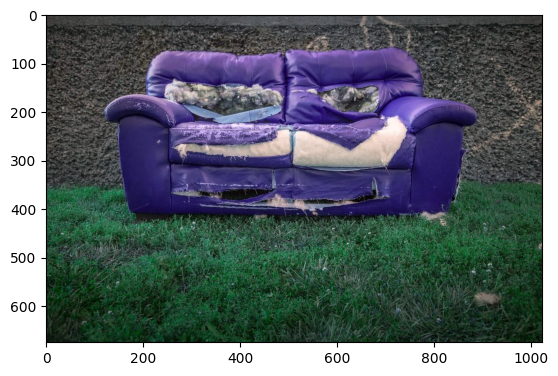

In [7]:
item_image = read_image(IMAGE_PATH)
display_image(item_image)

## Classification of the item on the image

In [8]:
"""
Now let's actually check what kind of object are we dealing with."""

import torch

from transformers import AutoFeatureExtractor, ResNetForImageClassification

In [9]:
ITEM_CLASSIFICATION_MODEL_NAME = "microsoft/resnet-18"

In [10]:
feature_extractor = AutoFeatureExtractor.from_pretrained(ITEM_CLASSIFICATION_MODEL_NAME)
model = ResNetForImageClassification.from_pretrained(ITEM_CLASSIFICATION_MODEL_NAME)

C:\Users\Aleksander\Desktop\STARTHACK\Galak-Pizza-Forever\starthack\Lib\site-packages\transformers\models\convnext\feature_extraction_convnext.py:28: FutureWarning: The class ConvNextFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ConvNextImageProcessor instead.
  warnings.warn(


In [11]:
def get_prediction(image: np.ndarray) -> str:
    inputs = feature_extractor(image, return_tensors="pt")
    
    with torch.no_grad():
        logits = model(**inputs).logits
    
    predicted_label = logits.argmax(-1).item()
    return model.config.id2label[predicted_label]

In [12]:
pred_class = get_prediction(item_image)
print(pred_class)

studio couch, day bed


### Disallowed items

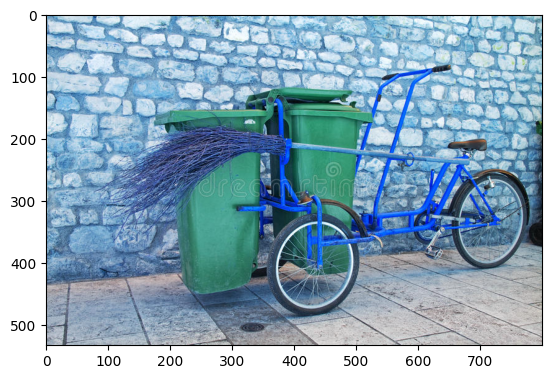

In [13]:
"""Some items cannot be treated as bulk garbage. The example if this is a bicycle.
Let's suppose we received a photo of just that."""

bike_image = read_image("bike.jpg")
display_image(bike_image)

In [14]:
dissallowed_class = get_prediction(bike_image)
print(dissallowed_class)  # we can capture it and inform the user that this will not be accepted

tricycle, trike, velocipede


## Draw bounding boxes - the gateway to estimate the number of stamps

In [15]:
"""
We can use the images to estimate the price that needs to be paid for the item's collection"""

import tensorflow as tf

In [16]:
# Load the pre-trained model
model_name = 'faster_rcnn_resnet50_v1_640x640_coco17_tpu-8'
model_dir = 'models/' + model_name + '/saved_model'
model = tf.saved_model.load(model_dir)

# Define the input and output tensors
input_tensor = model.signatures['serving_default'].inputs[0]
output_tensor = model.signatures['serving_default'].outputs

In [17]:
image_tensor = tf.convert_to_tensor(item_image)
image_tensor = tf.expand_dims(image_tensor, 0)

# Predict bounding boxes
output_dict = model(image_tensor)

# Extract the bounding boxes and confidence scores
boxes = output_dict['detection_boxes'][0].numpy()
scores = output_dict['detection_scores'][0].numpy()

# Filter out low confidence scores
high_conf_boxes = boxes[scores > 0.5]

# Display the image with the predicted bounding boxes
for box in high_conf_boxes:
    ymin, xmin, ymax, xmax = box
    ymin = int(ymin * item_image.shape[0])
    xmin = int(xmin * item_image.shape[1])
    ymax = int(ymax * item_image.shape[0])
    xmax = int(xmax * item_image.shape[1])
    cv2.rectangle(item_image, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)
    image_with_text = cv2.putText(item_image, pred_class,  (xmin, ymin-20), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255,255,255), 1)

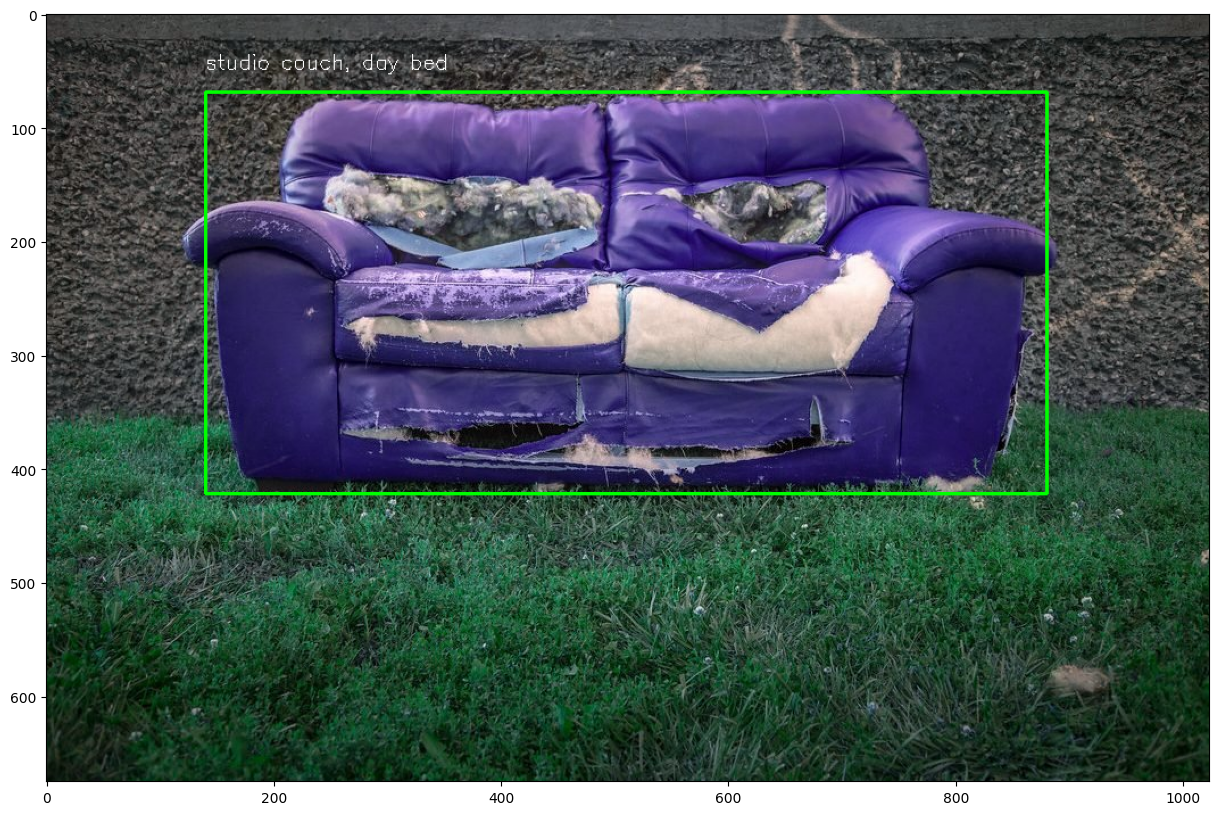

In [23]:
plt.figure(figsize=(15,10))
display_image(image_with_text)

In [18]:
"""
Let's suppose that we obtained a weight and size estimation. We can now calculate the number of stamps that need
to be purchased"""

MAX_WEIGHT = 30  # kg
MAX_LEN = 200  # cm
MAX_WIDTH = 90  # cm

def calculate_num_stamps(weight: float, length: float, width: float) -> int:
    return max(
    weight // MAX_WEIGHT,
    length // MAX_LEN,
    width // MAX_WIDTH
    ) + 1


In [19]:
item_weight = 50
item_lenght = 210
item_width = 70

num_stamps = calculate_num_stamps(
    item_weight,
    item_lenght,
    item_width,
)

print(f"Number of stamps required for this item: {num_stamps}")

Number of stamps required for this item: 2
